<a href="https://colab.research.google.com/github/kieransfwoodward/Somabotics/blob/main/Transformer_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.layers import Layer, Add, Embedding, GlobalAveragePooling1D, Concatenate, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import train_test_split
# from scipy.signal import savgol_filter, medfilt
import time
import json
from joblib import load

save_dir = 'progressive_hug_results'

scaler = RobustScaler()
scaler = load('progressive_hug_results/scaler.joblib')

In [ ]:
def generate_with_progressive_conditioning(
    model,
    seed_sequence,
    scaler,
    target_length,
    window_size,
    feature_dim,
    step_size=80,           # Larger step size to reduce repetition
    transition_frames=10,   # Moderate transition frames
    noise_level=0.02        # Noise to break repetitive patterns
):

    # Start with seed sequence
    generated_sequence = seed_sequence.copy()
    generated_frames = generated_sequence.reshape(-1, feature_dim)

    # Keep track of context sizes to progressively increase
    context_size = min(len(generated_frames), window_size // 2)

    # Keep a longer history for better global structure
    history_buffer = generated_frames.copy()

    # Generate the sequence step by step
    print(f"Starting generation with initial context of {context_size} frames...")
    while len(generated_frames) < target_length:
        # Get the current context from the history buffer
        if len(history_buffer) <= context_size:
            current_context = history_buffer
        else:
            current_context = history_buffer[-context_size:]

        model_input = current_context.reshape(1, -1, feature_dim)

        # Generate the next window
        next_window = model.predict(model_input, verbose=0)[0]

        # Add small random noise to break repetitive patterns
        noise = np.random.normal(0, noise_level, next_window.shape)
        next_window = next_window + noise

        # Clip predicted values
        next_window = np.clip(next_window, -3.0, 3.0)

        # Keep only step_size frames from the prediction
        frames_to_keep = min(step_size, target_length - len(generated_frames))
        if frames_to_keep <= 0:
            break

        frames_to_append = next_window[:frames_to_keep]

        # Apply smoothing between the last frame of current sequence and first frame of new prediction
        if len(generated_frames) > 0:
            # Get the last frame of the current sequence
            last_frame = generated_frames[-1:].copy()
            # Get the first frame of the new prediction
            first_new_frame = frames_to_append[0:1].copy()

            # Create a smooth transition
            transition_frames_count = min(transition_frames, len(frames_to_append))
            transition = np.zeros((transition_frames_count, feature_dim))

            for i in range(transition_frames_count):
                # Smooth cubic interpolation weight
                t = (i + 1) / (transition_frames_count + 1)
                weight = t * t * (3 - 2 * t)
                transition[i] = last_frame * (1 - weight) + first_new_frame * weight

            # Replace first few frames with the transition
            frames_to_append[:transition_frames_count] = transition

        # Append to the generated sequence
        generated_frames = np.vstack([generated_frames, frames_to_append])

        # Add to history buffer, but randomly drop some older frames to prevent pattern lock
        if len(history_buffer) > window_size * 1.5:
            # Keep recent frames and a selection of older ones
            recent_keep = int(window_size * 0.7)
            older_frames = history_buffer[:-recent_keep]
            # Keep about half of the older frames randomly
            keep_indices = np.random.choice(
                len(older_frames),
                size=min(len(older_frames) // 2, window_size),
                replace=False
            )
            keep_indices = np.sort(keep_indices)
            history_buffer = np.vstack([older_frames[keep_indices], history_buffer[-recent_keep:]])

        # Add new frames to history buffer
        history_buffer = np.vstack([history_buffer, frames_to_append])

        # Progressively increase context size
        if context_size < window_size:
            context_size = min(context_size + step_size // 4, window_size)

        print(f"Generated {len(generated_frames)}/{target_length} frames, context size: {context_size}", end="\r")

    print(f"\nGeneration complete. Final sequence shape: {generated_frames.shape}")

    # Apply a multi-stage smoothing process to remove noise while preserving trends

    # 1. First pass with a small window to preserve general shape
    smoothed_frames = np.zeros_like(generated_frames)
    small_window = min(21, len(generated_frames) // 5)
    small_window = small_window if small_window % 2 == 1 else small_window - 1

    if small_window >= 5:
        for i in range(generated_frames.shape[1]):
            try:
                smoothed_frames[:, i] = savgol_filter(generated_frames[:, i], small_window, 3)
            except Exception as e:
                print(f"Warning: First smoothing pass failed: {e}")
                smoothed_frames[:, i] = generated_frames[:, i]
    else:
        smoothed_frames = generated_frames.copy()

    # 2. Trend extraction with a larger window
    trend_component = np.zeros_like(smoothed_frames)
    large_window = min(101, len(generated_frames) // 3)
    large_window = large_window if large_window % 2 == 1 else large_window - 1

    if large_window >= 11:
        for i in range(smoothed_frames.shape[1]):
            try:
                trend_component[:, i] = savgol_filter(smoothed_frames[:, i], large_window, 3)
            except Exception as e:
                print(f"Warning: Trend extraction failed: {e}")
                trend_component[:, i] = smoothed_frames[:, i]

        # 3. Blend trend (70%) with detail (30%) to preserve some natural variation
        final_smoothed = 0.7 * trend_component + 0.3 * smoothed_frames
    else:
        final_smoothed = smoothed_frames

    # 4. Apply median filter to remove remaining spikes
    from scipy.signal import medfilt
    for i in range(final_smoothed.shape[1]):
        try:
            final_smoothed[:, i] = medfilt(final_smoothed[:, i], min(11, len(final_smoothed) // 10))
        except Exception as e:
            print(f"Warning: Median filtering failed: {e}")

    # Rescale to original range
    generated_sequence_rescaled = scaler.inverse_transform(final_smoothed)

    return generated_sequence_rescaled

In [ ]:
def build_progressive_transformer(
    max_sequence_length,
    feature_dim,
    embed_dim=128, #was 64
    num_heads=6, #was 4
    ff_dim=256, #was 128
    num_transformer_blocks=5, #was 3
    mlp_units=[128, 64],
    dropout=0.1,
    window_size=400
):

    # Input sequence with variable length (None)
    inputs = Input(shape=(None, feature_dim))

    # Create a mask from the inputs using a custom layer
    mask = MaskCreationLayer()(inputs)

    # Initial embedding and normalisation
    x = LayerNormalization(epsilon=1e-5)(inputs)
    x = Dense(embed_dim, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(x)

    # Add positional embedding
    positions = tf.keras.layers.Lambda(
        lambda shape: tf.range(shape[1]),
        output_shape=(None,)
    )(tf.keras.layers.Lambda(lambda x: tf.shape(x))(x))

    position_embedding = Embedding(
        input_dim=max_sequence_length,
        output_dim=embed_dim,
        embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    )(positions)

    # Apply the embeddings
    x = Add()([x, position_embedding])

    # Apply dropout
    x = Dropout(dropout)(x)

    # Transformer blocks - manually creating attention masks in each block
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)(x)

    # Final normalisation
    x = LayerNormalization(epsilon=1e-5)(x)

    # Global pooling with masking using custom layer
    global_features = MaskedGlobalAveragePooling()([x, mask])

    # MLP head
    for dim in mlp_units:
        global_features = Dense(
            dim,
            activation="selu",
            kernel_initializer="lecun_normal"
        )(global_features)
        global_features = Dropout(dropout)(global_features)

    # Output layer for next window prediction (predict a window the same size as training window)
    outputs = Dense(
        window_size * feature_dim,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)
    )(global_features)
    outputs = tf.keras.layers.Reshape((window_size, feature_dim))(outputs)

    return Model(inputs, outputs)

In [ ]:
class MaskCreationLayer(Layer):
    def __init__(self, **kwargs):
        super(MaskCreationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Create a mask for non-zero values
        return tf.reduce_any(tf.not_equal(inputs, 0), axis=-1)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class MaskedGlobalAveragePooling(Layer):
    def __init__(self, **kwargs):
        super(MaskedGlobalAveragePooling, self).__init__(**kwargs)

    def call(self, inputs):
        x, mask = inputs
        # Expand mask for broadcasting
        mask = tf.expand_dims(tf.cast(mask, x.dtype), -1)
        # Apply mask to zero out padded regions
        masked_x = x * mask
        # Calculate sequence lengths for averaging
        sequence_lengths = tf.reduce_sum(mask, axis=1)
        # Avoid division by zero
        sequence_lengths = tf.maximum(sequence_lengths, 1.0)
        # Sum and normalize
        return tf.reduce_sum(masked_x, axis=1) / sequence_lengths

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][2])

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()

        self.att = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            attention_axes=(1,2) #was (1,2)
        )

        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="gelu"),
            Dropout(rate),
            Dense(embed_dim, kernel_initializer="glorot_uniform"),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-5)
        self.layernorm2 = LayerNormalization(epsilon=1e-5)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.add1 = Add()
        self.add2 = Add()

    def call(self, inputs, training=None):
        normalized = self.layernorm1(inputs)

        # Basic attention without explicit mask
        attn_output = self.att(normalized, normalized)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.add1([inputs, attn_output])

        normalized2 = self.layernorm2(out1)
        ffn_output = self.ffn(normalized2)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.add2([out1, ffn_output])


In [ ]:
def custom_motion_loss(y_true, y_pred):
    # Position error (MSE)
    position_mse = tf.reduce_mean(tf.square(y_true - y_pred))

    # Velocity smoothness (penalize sudden changes)
    true_vel = y_true[:, 1:] - y_true[:, :-1]
    pred_vel = y_pred[:, 1:] - y_pred[:, :-1]
    velocity_smoothness = tf.reduce_mean(tf.square(true_vel - pred_vel))

    # Combined loss with weighting
    return position_mse + 0.5 * velocity_smoothness

In [ ]:
def load_model(save_dir):
    with open(os.path.join(save_dir, 'params.json'), 'r') as f:
        params = json.load(f)

    model = build_progressive_transformer(
        max_sequence_length=params['max_sequence_length'],
        feature_dim=params['feature_dim'],
        embed_dim=params['embed_dim'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        num_transformer_blocks=params['num_transformer_blocks'],
        mlp_units=params['mlp_units'],
        dropout=params['dropout'],
        window_size=params['window_size']
    )

    # Compile model
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=0.001,
            first_decay_steps=500,
            t_mul=2.0,
            m_mul=0.9,
            alpha=0.1
        ),
        clipnorm=1.0
    )

    model.compile(
        optimizer=optimizer,
        loss=custom_motion_loss,
        metrics=['mae']
    )

    # Load weights
    model.load_weights(os.path.join(save_dir, 'weights.weights.h5'))

    print(f"Model loaded from {save_dir}")
    return model

model = load_model('progressive_hug_results')


Model loaded from progressive_hug_results


In [ ]:
def collect_seed(num_samples=400):
    print(f"Collecting {num_samples} samples")

    positions = np.zeros((num_samples, 7))
    velocities = np.zeros((num_samples, 7))

    for i in range(num_samples):
        positions[i] = np.random.uniform(-1.5, 1.5, 7)  # Simulated robot data

        # Calculate velocity (as model still needs this currently) OR get from robot
        if i > 0:
            velocities[i] = positions[i] - positions[i-1]

    # Combine positions and velocities
    seed_sequence = np.column_stack((positions, velocities))

    # # Scale using your existing scaler
    scaled_seed = scaler.transform(seed_sequence)
    scaled_seed = np.clip(scaled_seed, -3.0, 3.0)

    print("Collection complete!")
    return seed_sequence

# Collect seed and generate sequence
seed_sequence = collect_seed(params['window_size'])



Collection complete!


Starting generation with initial context of 200 frames...
Generated 2000/2000 frames, context size: 400
Generation complete. Final sequence shape: (2000, 14)

Progressive conditioning hug sequence generation successful!
Generated sequence saved to progressive_hug_results/generated_hug_sequence.csv


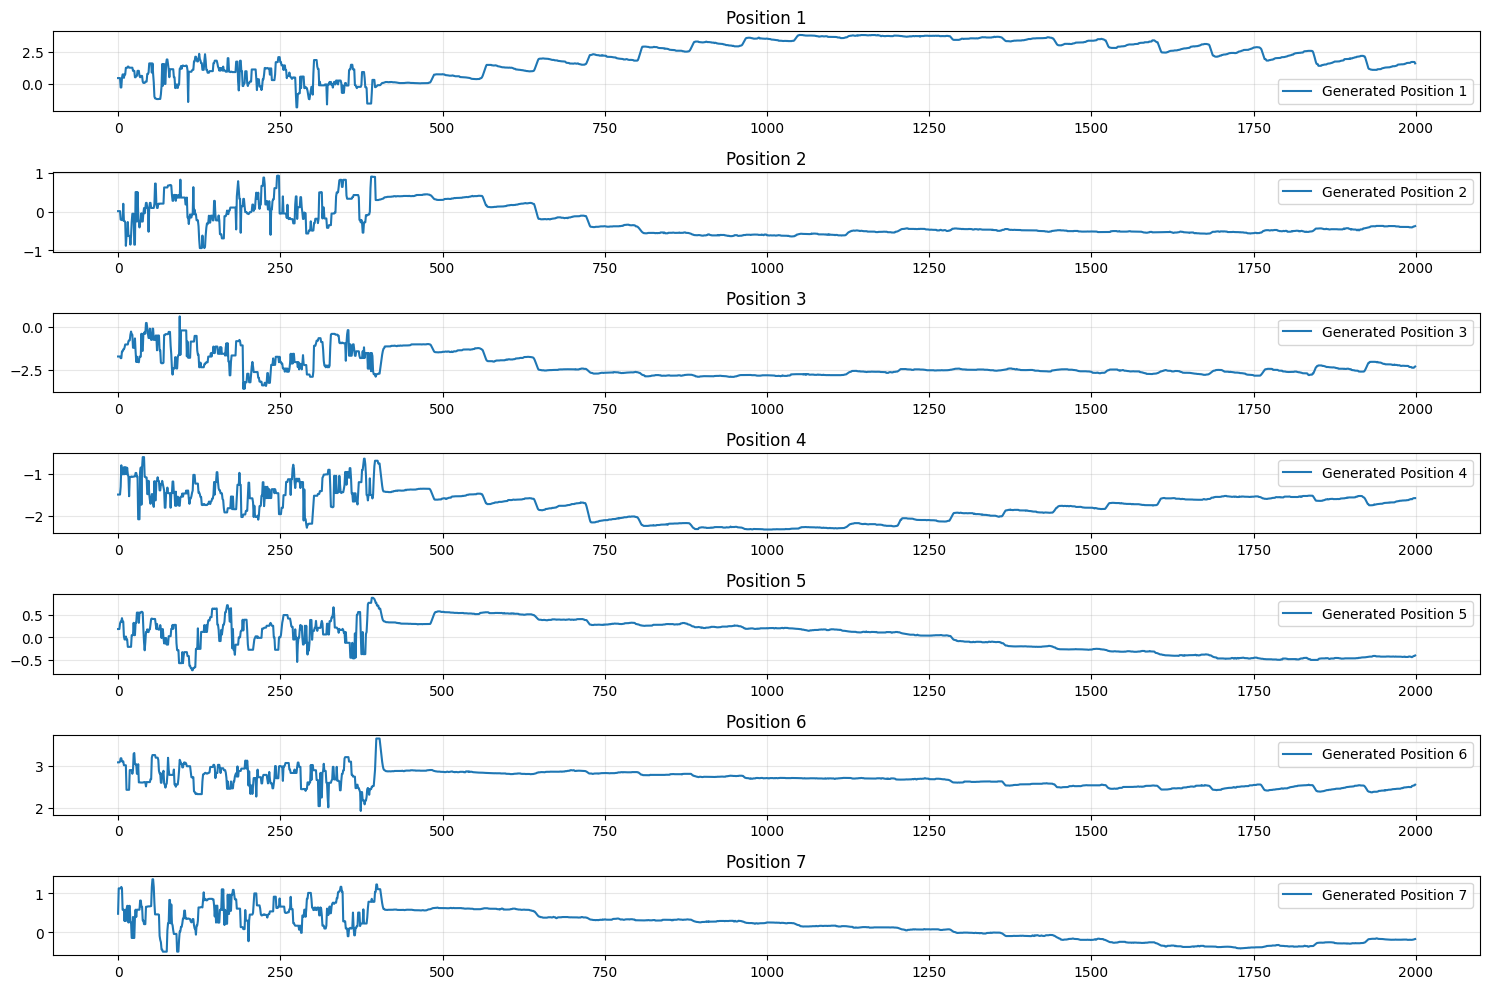

In [ ]:
target_length = 2000 #1 minute 40 seconds at 20hz
feature_dim = seed_sequence.shape[1]

# Generate sequence using progressive conditioning
generated_sequence = generate_with_progressive_conditioning(
    model,
    seed_sequence,
    scaler,
    target_length,
    400,
    feature_dim,
    step_size=80,           # Larger step size to reduce repetition
    transition_frames=10,   # Moderate transition frames
    noise_level=0.02        # Small noise to break repetitive patterns
)

plt.figure(figsize=(15, 10))

# Plot positions (first 7 features are positions)
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(generated_sequence[:, i], label=f'Generated Position {i+1}')
    plt.title(f'Position {i+1}')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()

pd.DataFrame(
    generated_sequence,
    columns=[f'Position{i}' for i in range(1, 8)] + [f'Velocity{i}' for i in range(1, 8)]
).to_csv(os.path.join(save_dir, 'generated_hug_sequence.csv'), index=False)

print("\nProgressive conditioning hug sequence generation successful!")
print(f"Generated sequence saved to {os.path.join(save_dir, 'generated_hug_sequence.csv')}")


In [ ]:
!mjpython /Users/pszkw/mujoco_panda/mujoco_panda/paused_movement.py /Users/pszkw/progressive_hug_results/generated_hug_sequence.csv

Starting playback...


KeyboardInterrupt: 